In [6]:
!pip -q install seaborn
!pip -q install nltk

In [7]:
import json
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns;
from collections import defaultdict
from utils import *
from search_engine import *
from numpy.random import choice
from tqdm.notebook import tqdm

In [38]:
topics, documents, qrels = parse_squad()

In [39]:
mapping = { 
    "Harvard_University":'1_harvard',
    "Black_Death":'2_blackdeath',
    "Intergovernmental_Panel_on_Climate_Change":'3_ipcc',
    "Geology":'5_geology',
    "Economic_inequality":'6_economicinequality',
    "Immune_system":'7_immunesystem',
    "Oxygen":'8_oxygen'}

for topic in list(topics.keys()):
    if topic in mapping:
        topics[mapping[topic]] = topics[topic]
        documents[mapping[topic]] = documents[topic]
        del documents[topic]
        qrels[mapping[topic]] = qrels[topic]
    del topics[topic]
    del qrels[topic]

In [40]:
def get_queries(queries, document_id):
    res = {}
    for query_id, query in queries.items():
        if query_id[0] == document_id:
            res[query_id] = query
    return res

def get_document_to_subtopics(topic_id):
    res = {}
    with open("t" + topic_id + "_prels.tsv", "r") as f:
        for line in f.readlines():
            items = line.split("\t")
            sub_topics = items[1]
            document_id = int(items[0])
            if sub_topics:
                for sub_topic in sub_topics.strip().split(' '):
                    sub_topic = int(sub_topic)
                    if document_id not in res:
                        res[document_id] = set()
                    res[document_id].add(sub_topic)
    return res

def get_document_to_subtopics_based_on_users(topic):
    res = {}
    qrels = get_qrels(topic)
    sequence_list = get_sequence_list(topic, qrels)
    for sequence in sequence_list:
        for item in sequence:
            if item[4]:
                document = item[1]
                if document not in res:
                    res[document] = set()
                res[document].add(item[3])
    return res

def get_subtopics_to_queries(queries, document_to_subtopics): 
    subtopics_to_queries = defaultdict(list)
    for document_id, subtopic_ids in document_to_subtopics.items():
        for subtopic_id in subtopic_ids:
            for query_id, query in get_queries(queries, document_id).items():
                subtopics_to_queries[subtopic_id].append(query)
    return subtopics_to_queries

def get_topics_from_users(topic):
    res = {}
    qrels = get_qrels(topic)
    sequence_list = get_sequence_list(topic, qrels)
    for sequence_id, sequence in enumerate(sequence_list):
        for item in sequence:
            query = item[5]
            if item[3] not in res:
                res[item[3]] = []
            res[item[3]].append(query)
    return res

In [41]:
# Execute for Dataset Relevance
topics_to_subtopics_to_queries = {}
topics_to_documents_to_subtopics = {} # dataset relevance
for topic_id in topics:
    document_to_subtopics = get_document_to_subtopics(topic_id)
    topics_to_documents_to_subtopics[topic_id] = document_to_subtopics
    queries = topics[topic_id]
    topics_to_subtopics_to_queries[topic_id] = get_subtopics_to_queries(queries, document_to_subtopics)

In [42]:
# Execute this to get user query and relevance 
topics_to_subtopics_to_queries = {}
topics_to_documents_to_subtopics = {} # user relevance
for topic_id in topics:
    document_to_subtopics = get_document_to_subtopics_based_on_users(topic_id)
    topics_to_documents_to_subtopics[topic_id] = document_to_subtopics
    topics_to_subtopics_to_queries[topic_id] = get_topics_from_users(topic_id)

In [43]:
def get_search_engine(topic_id, noise = 0.0):
    # select documents belonging to the topic
    selected_documents = {}
    selected_documents[topic_id] = {}
    all_documents = {}
    all_documents[topic_id] = {}
    for document_id in documents[topic_id]:
        if document_id in topics_to_documents_to_subtopics[topic_id]:
            selected_documents[topic_id][document_id] = documents[topic_id][document_id]
        
    for t_id in documents:
        for document_id in documents[t_id]:
            all_documents[topic_id][document_id] = documents[t_id][document_id]
    
    # select random documents
    if noise > 0:
        for t_id in documents:
            if t_id not in selected_documents:
                selected_documents[t_id] = {}
            n_d = int(noise * len(documents[t_id]))
            d_ids = choice(len(documents[t_id]), size = n_d, replace = False)
            documents_list = list(documents[t_id].items())
            for d_id in d_ids:
                selected_documents[t_id][documents_list[d_id][0]] = documents_list[d_id][1]

    direct_index = get_direct_index(selected_documents)
    dictionary, cl, lengths, inverted_index = get_inverted_index(direct_index)
    
    direct_index_sm = get_direct_index(all_documents)
    dictionary_sm, cl_sm, lengths_sm, inverted_index_sm = get_inverted_index(direct_index_sm)
    
    return dictionary_sm, cl_sm, lengths, inverted_index

for topic_id in topics:
    print(topic_id)
    dictionary, cl, lengths, inverted_index = get_search_engine(topic_id, 0.0)
    print(search("oxygen", dictionary, cl, lengths, inverted_index, 100, 10))
    break

8_oxygen
[('8_oxygen', 301), ('8_oxygen', 286), ('8_oxygen', 282), ('8_oxygen', 264), ('8_oxygen', 296), ('8_oxygen', 283), ('8_oxygen', 294), ('8_oxygen', 304), ('8_oxygen', 290), (None, None)]


In [44]:
def use_pooled_relevance(sequence_list, topic_to_documents_to_subtopics):
    for sequence in sequence_list:
        for n, item in enumerate(sequence):
            is_rel = False
            if item[1] in topic_to_documents_to_subtopics:
                is_rel = item[3] in topic_to_documents_to_subtopics[item[1]]
                #print(is_rel, item[3], topics_to_documents_to_subtopics[topic][item[1]])
            sequence[n] = (item[0], item[1], item[2], item[3], is_rel, item[5])
            
ncbp_p_scores = []
ncbp_scores = []
ncp_scores = []
for topic in topics:
    qrels = get_qrels(topic)
    sequence_list = get_sequence_list(topic, qrels)
    use_pooled_relevance(sequence_list, topics_to_documents_to_subtopics[topic])
    ncbp_p_scores.append((topic, np.mean(get_ncbp_p_list(sequence_list, 1, 0.67))))
    ncbp_scores.append((topic, np.mean(get_ncbp_list(sequence_list, 0.85))))
    ncp_scores.append((topic, np.mean(get_ncp_list(sequence_list))))
    
ncbp_p_scores = sorted(ncbp_p_scores)
ncbp_scores = sorted(ncbp_scores)
ncp_scores = sorted(ncp_scores)
ncbp_p_scores, ncbp_scores, ncp_scores

([('1_harvard', 0.9464558621177265),
  ('2_blackdeath', 0.9140780938123753),
  ('3_ipcc', 0.9769319492502884),
  ('5_geology', 1.0),
  ('6_economicinequality', 0.9667221297836939),
  ('7_immunesystem', 0.9356500337866327),
  ('8_oxygen', 0.9560479041916168)],
 [('1_harvard', 0.6277635260670987),
  ('2_blackdeath', 0.6089353038304688),
  ('3_ipcc', 0.6897091933205275),
  ('5_geology', 0.7568113051347012),
  ('6_economicinequality', 0.6739542475804687),
  ('7_immunesystem', 0.7294231459463704),
  ('8_oxygen', 0.7515796682839179)],
 [('1_harvard', 0.9541666666666666),
  ('2_blackdeath', 0.9277777777777778),
  ('3_ipcc', 0.9777777777777776),
  ('5_geology', 1.0),
  ('6_economicinequality', 0.9714285714285715),
  ('7_immunesystem', 0.9527272727272728),
  ('8_oxygen', 0.9599999999999997)])

In [45]:
satisfaction_scores = []
for topic in topics:
    satisfaction_list = get_satisfaction_list(topic)
    satisfaction_scores.append((topic, np.mean(satisfaction_list)))

satisfaction_scores = sorted(satisfaction_scores)
satisfaction_scores

[('1_harvard', 0.8),
 ('2_blackdeath', 0.2),
 ('3_ipcc', 1.0),
 ('5_geology', 0.6),
 ('6_economicinequality', 0.8),
 ('7_immunesystem', 0.8),
 ('8_oxygen', 0.6)]

KendalltauResult(correlation=0.2646280620124816, pvalue=0.4272628567457064)

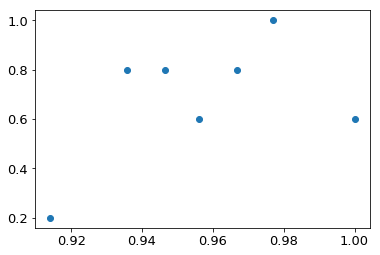

In [46]:
x = [i[1] for i in ncbp_p_scores]
y = [i[1] for i in satisfaction_scores]
plt.plot(x, y, 'o')
scipy.stats.kendalltau(x, y)

KendalltauResult(correlation=-0.05292561240249632, pvalue=0.8738446985173735)

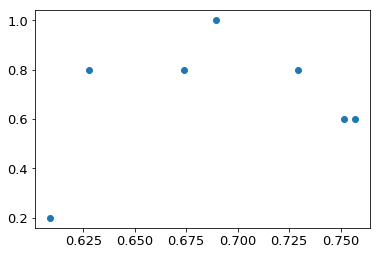

In [47]:
x = [i[1] for i in ncbp_scores]
y = [i[1] for i in satisfaction_scores]
plt.plot(x, y, 'o')
scipy.stats.kendalltau(x, y)

KendalltauResult(correlation=0.2646280620124816, pvalue=0.4272628567457064)


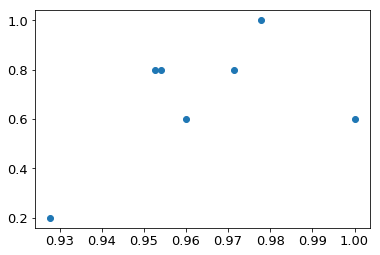

In [48]:
plt.plot([i[1] for i in ncp_scores], [i[1] for i in satisfaction_scores], 'o')
print(scipy.stats.kendalltau([i[1] for i in ncp_scores], [i[1] for i in satisfaction_scores]))

In [117]:
# transition probabilities for harvard
# comparison of a system with without filtering, or with noise
# compute transition on sessions using the transition probabilities.

mu = 1000
noise = 0.0

topic_scores = []
topic_scores_ses = []
for topic_id in tqdm(topics):
    num_subtopics = max(topics_to_subtopics_to_queries[topic_id].keys())
    dictionary, cl, lengths, inverted_index = get_search_engine(topic_id, noise)
    print(len(lengths))
    qrels = get_qrels(topic_id)
    # compute metric
    probs = []
    scores = []
    #for n in range(5000):
        #sequence, prob = generate_sequence(num_subtopics)
    sequence_list = get_sequence_list(topic_id, qrels)
    use_pooled_relevance(sequence_list, topics_to_documents_to_subtopics[topic_id])
    for sequence in sequence_list:
        #print(sequence)
        prob = 0.0
        probs.append(prob)
        score = 0.0
        ncbp_score = ncbp(sequence, 0.85)
        for m, item in enumerate(sequence):
            #print(sequence)
            item = (item[0], item[3], item[5], item[1])
            subtopic_id = item[1]
            is_rel = False
            if subtopic_id in topics_to_subtopics_to_queries[topic_id]:
                queries = topics_to_subtopics_to_queries[topic_id][subtopic_id]
                query = queries[choice(range(len(queries)))]
                query = item[2]
                
                answer = None
                #print(search(query, dictionary, cl, lengths, inverted_index, mu, 10))
                #print(topics_to_documents_to_subtopics[topic_id])
                for i, a in enumerate(search(query, dictionary, cl, lengths, inverted_index, mu, 100)):
                    if i == 0:
                        answer = a
                    temp = get_document_to_subtopics(topic_id)
                    #print(temp)
                    #print(a, subtopic_id, a[1] in temp, subtopic_id in temp[a[1]], temp[a[1]])
                    if a[1] in temp and subtopic_id in temp[a[1]]:
                        answer = a
                    break
                #print(answer, item[3])
                #answer = (topic_id, item[3]) 
                #print(answer)
                is_rel = False
                if answer != None:
                    #print(answer[1], subtopic_id, topics_to_documents_to_subtopics[topic_id])
                    if answer[1] in topics_to_documents_to_subtopics[topic_id]:
                        is_rel = subtopic_id in topics_to_documents_to_subtopics[topic_id][answer[1]]
            sequence[m] = (item[0], is_rel, is_rel, item[1], is_rel)
            
            if is_rel:
                score += dd_ncbp(0.85, m)
                #score += dd_cbp_p(1, 0.67, m, sequence)
                #score += dd_cp(sequence)
            #print("score", score, m, dd_ncbp(0.85, m), is_rel)
        #print("comparison", score, ncbp_score)
        scores.append(score)
    
    if scores:
        probs = np.array(probs)
        scores = np.array(scores)
        #topic_score = (scores @ probs) / probs.sum()
        topic_score = np.mean(scores)
        topic_scores.append((topic_id, topic_score))
    else:
        topic_scores.append((topic_id, 0.0))

#topic_scores = np.array(topic_scores)
system_scores = sorted(topic_scores)
system_scores


10
8
8
11
6
10
6



[('1_harvard', 0.2909235973243544),
 ('2_blackdeath', 0.44541888058710943),
 ('3_ipcc', 0.4231315742109375),
 ('5_geology', 0.47995130059918656),
 ('6_economicinequality', 0.37922076930703125),
 ('7_immunesystem', 0.5616523486941968),
 ('8_oxygen', 0.42587628319080767)]

In [118]:
ncbp_scores

[('1_harvard', 0.6277635260670987),
 ('2_blackdeath', 0.6089353038304688),
 ('3_ipcc', 0.6897091933205275),
 ('5_geology', 0.7568113051347012),
 ('6_economicinequality', 0.6739542475804687),
 ('7_immunesystem', 0.7294231459463704),
 ('8_oxygen', 0.7515796682839179)]

KendalltauResult(correlation=0.4285714285714286, pvalue=0.2388888888888889)

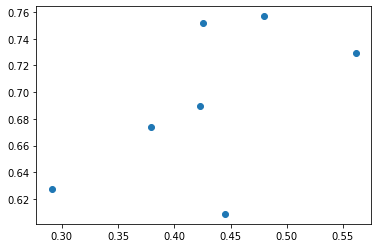

In [119]:
x = [i[1] for i in system_scores]
y = [i[1] for i in ncbp_scores]
plt.plot(x, y, 'o')
scipy.stats.kendalltau(x, y)

KendalltauResult(correlation=0.8095238095238096, pvalue=0.010714285714285714)

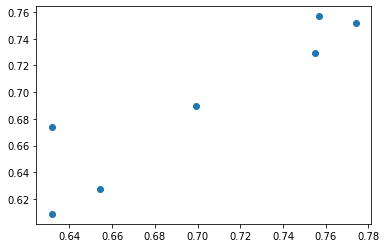

In [49]:
# transition probabilities for harvard
# comparison of a system with without filtering, or with noise
# compute transition on sessions using the transition probabilities.

mu = 1000
noise = 0.0

topic_scores = []
topic_scores_ses = []
for topic_id in tqdm(topics):
    num_subtopics = max(topics_to_subtopics_to_queries[topic_id].keys())
    dictionary, cl, lengths, inverted_index = get_search_engine(topic_id, noise)
    print(len(lengths))
    qrels = get_qrels(topic_id)
    # compute metric
    probs = []
    scores = []
    for n in range(5000):
        sequence, prob = generate_sequence(num_subtopics)
    #sequence_list = get_sequence_list(topic_id, qrels)
    #use_pooled_relevance(sequence_list, topics_to_documents_to_subtopics[topic_id])
    #for sequence in sequence_list:
        #print(sequence)
        prob = 0.0
        probs.append(prob)
        score = 0.0
        #ncbp_score = ncbp(sequence, 0.85)
        for m, item in enumerate(sequence):
            #print(sequence)
            #item = (item[0], item[3], item[5], item[1])
            subtopic_id = item[1]
            is_rel = False
            if subtopic_id in topics_to_subtopics_to_queries[topic_id]:
                queries = topics_to_subtopics_to_queries[topic_id][subtopic_id]
                query = queries[choice(range(len(queries)))]
                #query = item[2]
                
                answer = None
                #print(search(query, dictionary, cl, lengths, inverted_index, mu, 10))
                #print(topics_to_documents_to_subtopics[topic_id])
                for i, a in enumerate(search(query, dictionary, cl, lengths, inverted_index, mu, 100)):
                    if i == 0:
                        answer = a
                    temp = get_document_to_subtopics(topic_id)
                    #print(temp)
                    #print(a, subtopic_id, a[1] in temp, subtopic_id in temp[a[1]], temp[a[1]])
                    if a[1] in temp and subtopic_id in temp[a[1]]:
                        answer = a
                    break
                #print(answer, item[3])
                #answer = (topic_id, item[3]) 
                #print(answer)
                is_rel = False
                if answer != None:
                    #print(answer[1], subtopic_id, topics_to_documents_to_subtopics[topic_id])
                    if answer[1] in topics_to_documents_to_subtopics[topic_id]:
                        is_rel = subtopic_id in topics_to_documents_to_subtopics[topic_id][answer[1]]
            sequence[m] = (item[0], is_rel, is_rel, item[1], is_rel)
            
            if is_rel:
                score += dd_ncbp(0.85, m)
                #score += dd_cbp_p(1, 0.67, m, sequence)
                #score += dd_cp(sequence)
            #print("score", score, m, dd_ncbp(0.85, m), is_rel)
        #print("comparison", score, ncbp_score)
        scores.append(score)
    
    if scores:
        probs = np.array(probs)
        scores = np.array(scores)
        #topic_score = (scores @ probs) / probs.sum()
        topic_score = np.mean(scores)
        topic_scores.append((topic_id, topic_score))
    else:
        topic_scores.append((topic_id, 0.0))

#topic_scores = np.array(topic_scores)
system_scores_with_filtering = sorted(topic_scores)
system_scores_with_filtering

10
8
8
11
6
10
6



[('1_harvard', 0.2232323007420825),
 ('2_blackdeath', 0.3210107293417197),
 ('3_ipcc', 0.2894085353238028),
 ('5_geology', 0.3523840779735315),
 ('6_economicinequality', 0.23053861228416045),
 ('7_immunesystem', 0.3593634265369536),
 ('8_oxygen', 0.2924852589583538)]

In [134]:
# transition probabilities for harvard
# comparison of a system with without filtering, or with noise
# compute transition on sessions using the transition probabilities.

mu = 1000
noise = 0.0

topic_scores = []
topic_scores_ses = []
for topic_id in tqdm(topics):
    num_subtopics = max(topics_to_subtopics_to_queries[topic_id].keys())
    dictionary, cl, lengths, inverted_index = get_search_engine(topic_id, noise)
    print(len(lengths))
    qrels = get_qrels(topic_id)
    # compute metric
    probs = []
    scores = []
    for n in range(5000):
        sequence, prob = generate_sequence(num_subtopics)
    #sequence_list = get_sequence_list(topic_id, qrels)
    #use_pooled_relevance(sequence_list, topics_to_documents_to_subtopics[topic_id])
    #for sequence in sequence_list:
        #print(sequence)
        prob = 0.0
        probs.append(prob)
        score = 0.0
        #ncbp_score = ncbp(sequence, 0.85)
        for m, item in enumerate(sequence):
            #print(sequence)
            #item = (item[0], item[3], item[5], item[1])
            subtopic_id = item[1]
            is_rel = False
            if subtopic_id in topics_to_subtopics_to_queries[topic_id]:
                queries = topics_to_subtopics_to_queries[topic_id][subtopic_id]
                query = queries[choice(range(len(queries)))]
                #query = item[2]
                
                answer = None
                #print(search(query, dictionary, cl, lengths, inverted_index, mu, 10))
                #print(topics_to_documents_to_subtopics[topic_id])
                for i, a in enumerate(search(query, dictionary, cl, lengths, inverted_index, mu, 100)):
                    answer = a
                    break
                #print(answer, item[3])
                #answer = (topic_id, item[3]) 
                #print(answer)
                is_rel = False
                if answer != None:
                    #print(answer[1], subtopic_id, topics_to_documents_to_subtopics[topic_id])
                    if answer[1] in topics_to_documents_to_subtopics[topic_id]:
                        is_rel = subtopic_id in topics_to_documents_to_subtopics[topic_id][answer[1]]
            sequence[m] = (item[0], is_rel, is_rel, item[1], is_rel)
            
            if is_rel:
                score += dd_ncbp(0.85, m)
                #score += dd_cbp_p(1, 0.67, m, sequence)
                #score += dd_cp(sequence)
            #print("score", score, m, dd_ncbp(0.85, m), is_rel)
        #print("comparison", score, ncbp_score)
        scores.append(score)
    
    if scores:
        probs = np.array(probs)
        scores = np.array(scores)
        #topic_score = (scores @ probs) / probs.sum()
        topic_score = np.mean(scores)
        topic_scores.append((topic_id, topic_score))
    else:
        topic_scores.append((topic_id, 0.0))

#topic_scores = np.array(topic_scores)
system_scores_without_filtering = sorted(topic_scores)
system_scores_without_filtering

10
8
8
11
6
10
6



[('1_harvard', 0.223574050705833),
 ('2_blackdeath', 0.31966036627811983),
 ('3_ipcc', 0.2863790763559097),
 ('5_geology', 0.3493856327324293),
 ('6_economicinequality', 0.22914499789676906),
 ('7_immunesystem', 0.35505738659249403),
 ('8_oxygen', 0.29576036846122333)]

KendalltauResult(correlation=1.0, pvalue=0.0003968253968253968)
0.2941374112889683 0.29423468411951653


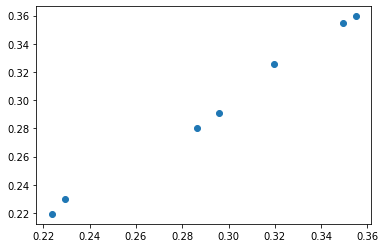

In [135]:
x = [i[1] for i in system_scores_without_filtering]
y = [i[1] for i in system_scores_with_filtering]
plt.plot(x, y, 'o')
print(scipy.stats.kendalltau(x, y))
print(np.mean(x), np.mean(y))

KendalltauResult(correlation=0.4285714285714286, pvalue=0.2388888888888889)
0.6911680557376504 0.29548899159437203


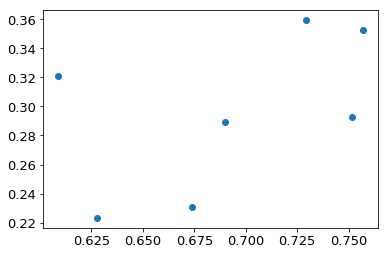

In [51]:
x = [i[1] for i in ncbp_scores]
y = [i[1] for i in system_scores_with_filtering]
plt.plot(x, y, 'o')
print(scipy.stats.kendalltau(x, y))
print(np.mean(x), np.mean(y))

In [65]:
# transition probabilities for harvard
# comparison of a system with without filtering, or with noise
# compute transition on sessions using the transition probabilities.

noises = []
system_scores = []

mu = 1000

noise = 0.0
topic_scores = []
topic_scores_ses = []
for topic_id in topics:
    num_subtopics = max(topics_to_subtopics_to_queries[topic_id].keys())
    dictionary, cl, lengths, inverted_index = get_search_engine(topic_id, noise)

    transitions_list = get_transitions_list(topic_id)
    table = get_transitions_table(num_subtopics, transitions_list, 0.001)

    qrels = get_qrels(topic_id)
    # compute metric
    probs = []
    scores = []
    for n in range(50000):
        sequence, prob = generate_sequence_from_table(num_subtopics, table)
    #sequence_list = get_sequence_list(topic_id, qrels)
    #use_pooled_relevance(sequence_list, topics_to_documents_to_subtopics[topic_id])
    #for sequence in sequence_list:
        #print(sequence)
        prob = 0.0
        probs.append(prob)
        score = 0.0
        #ncbp_score = ncbp(sequence, 0.85)
        for m, item in enumerate(sequence):
            #print(sequence)
            #item = (item[0], item[3], item[5], item[1])
            subtopic_id = item[1]
            is_rel = False
            if subtopic_id in topics_to_subtopics_to_queries[topic_id]:
                queries = topics_to_subtopics_to_queries[topic_id][subtopic_id]
                query = queries[choice(range(len(queries)))]
                #query = item[2]

                answer = None
                #print(search(query, dictionary, cl, lengths, inverted_index, mu, 10))
                #print(topics_to_documents_to_subtopics[topic_id])
                for i, a in enumerate(search(query, dictionary, cl, lengths, inverted_index, mu, 100)):
                    answer = a
                    break
                #print(answer, item[3])
                #answer = (topic_id, item[3]) 
                #print(answer)
                is_rel = False
                if answer != None:
                    #print(answer[1], subtopic_id, topics_to_documents_to_subtopics[topic_id])
                    if answer[1] in topics_to_documents_to_subtopics[topic_id]:
                        is_rel = subtopic_id in topics_to_documents_to_subtopics[topic_id][answer[1]]
            sequence[m] = (item[0], is_rel, is_rel, item[1], is_rel)

            if is_rel:
                score += dd_ncbp(0.85, m)
                #score += dd_cbp_p(1, 0.67, m, sequence)
                #score += dd_cp(sequence)
            #print("score", score, m, dd_ncbp(0.85, m), is_rel)
        #print("comparison", score, ncbp_score)
        scores.append(score)

    if scores:
        probs = np.array(probs)
        scores = np.array(scores)
        #topic_score = (scores @ probs) / probs.sum()
        topic_score = np.mean(scores)
        topic_scores.append((topic_id, topic_score))
    else:
        topic_scores.append((topic_id, 0.0))

topic_scores = sorted(topic_scores)
topic_scores

[('1_harvard', 0.2777055198598928),
 ('2_blackdeath', 0.3660545565305837),
 ('3_ipcc', 0.3140713038052152),
 ('5_geology', 0.4128958334818044),
 ('6_economicinequality', 0.3110122983675753),
 ('7_immunesystem', 0.485451460564658),
 ('8_oxygen', 0.35235702523737933)]

In [66]:
ncbp_scores

[('1_harvard', 0.6277635260670987),
 ('2_blackdeath', 0.6089353038304688),
 ('3_ipcc', 0.6897091933205275),
 ('5_geology', 0.7568113051347012),
 ('6_economicinequality', 0.6739542475804687),
 ('7_immunesystem', 0.7294231459463704),
 ('8_oxygen', 0.7515796682839179)]

KendalltauResult(correlation=0.4285714285714286, pvalue=0.2388888888888889)
0.6911680557376504 0.35993542826387265


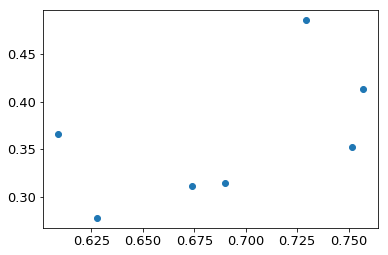

In [67]:
x = [i[1] for i in ncbp_scores]
y = [i[1] for i in topic_scores]
plt.plot(x, y, 'o')
print(scipy.stats.kendalltau(x, y))
print(np.mean(x), np.mean(y))

# Analysis of The Noise

In [140]:
# transition probabilities for harvard
# comparison of a system with without filtering, or with noise
# compute transition on sessions using the transition probabilities.

noises = []
system_scores = []

mu = 1000

for noise in tqdm(range(0, 11, 1)):
    noise /= 10
    topic_scores = []
    topic_scores_ses = []
    for topic_id in topics:
        num_subtopics = max(topics_to_subtopics_to_queries[topic_id].keys())
        dictionary, cl, lengths, inverted_index = get_search_engine(topic_id, noise)
        
        qrels = get_qrels(topic_id)
        # compute metric
        probs = []
        scores = []
        for n in range(10000):
            sequence, prob = generate_sequence(num_subtopics)
        #sequence_list = get_sequence_list(topic_id, qrels)
        #use_pooled_relevance(sequence_list, topics_to_documents_to_subtopics[topic_id])
        #for sequence in sequence_list:
            #print(sequence)
            prob = 0.0
            probs.append(prob)
            score = 0.0
            #ncbp_score = ncbp(sequence, 0.85)
            for m, item in enumerate(sequence):
                #print(sequence)
                #item = (item[0], item[3], item[5], item[1])
                subtopic_id = item[1]
                is_rel = False
                if subtopic_id in topics_to_subtopics_to_queries[topic_id]:
                    queries = topics_to_subtopics_to_queries[topic_id][subtopic_id]
                    query = queries[choice(range(len(queries)))]
                    #query = item[2]

                    answer = None
                    #print(search(query, dictionary, cl, lengths, inverted_index, mu, 10))
                    #print(topics_to_documents_to_subtopics[topic_id])
                    for i, a in enumerate(search(query, dictionary, cl, lengths, inverted_index, mu, 100)):
                        answer = a
                        break
                    #print(answer, item[3])
                    #answer = (topic_id, item[3]) 
                    #print(answer)
                    is_rel = False
                    if answer != None:
                        #print(answer[1], subtopic_id, topics_to_documents_to_subtopics[topic_id])
                        if answer[1] in topics_to_documents_to_subtopics[topic_id]:
                            is_rel = subtopic_id in topics_to_documents_to_subtopics[topic_id][answer[1]]
                sequence[m] = (item[0], is_rel, is_rel, item[1], is_rel)

                if is_rel:
                    score += dd_ncbp(0.85, m)
                    #score += dd_cbp_p(1, 0.67, m, sequence)
                    #score += dd_cp(sequence)
                #print("score", score, m, dd_ncbp(0.85, m), is_rel)
            #print("comparison", score, ncbp_score)
            scores.append(score)

        if scores:
            probs = np.array(probs)
            scores = np.array(scores)
            #topic_score = (scores @ probs) / probs.sum()
            topic_score = np.mean(scores)
            topic_scores.append((topic_id, topic_score))
        else:
            topic_scores.append((topic_id, 0.0))
        
    noises.append(noise)
    system_scores.append(np.mean([i[1] for i in topic_scores]))
    #print(np.mean([i[1] for i in topic_scores]))
        
#topic_scores = np.array(topic_scores)
system_scores

[0.29569536565757326,
 0.25566272889304603,
 0.2200096240104907,
 0.21705390436049662,
 0.19913532882081886,
 0.1761123043706127,
 0.18162499004679036,
 0.1723311495007595,
 0.16593335022127867,
 0.15674931928950575,
 0.15588757104363732]

KendalltauResult(correlation=-0.9636363636363636, pvalue=5.511463844797178e-07)
0.5 0.19965414874681908


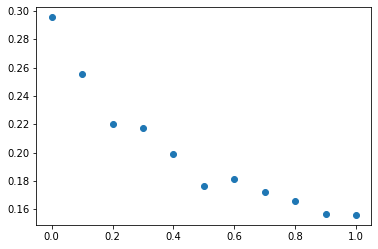

In [144]:
x = noises
y = system_scores
plt.plot(x, y, 'o')
print(scipy.stats.kendalltau(x, y))
print(np.mean(x), np.mean(y))

In [33]:
# transition probabilities for harvard
# comparison of a system with without filtering, or with noise
# compute transition on sessions using the transition probabilities.

noises = []
system_scores = []

mu = 1000

for noise in tqdm(range(0, 11, 1)):
    noise /= 10
    topic_scores = []
    topic_scores_ses = []
    for topic_id in topics:
        num_subtopics = max(topics_to_subtopics_to_queries[topic_id].keys())
        dictionary, cl, lengths, inverted_index = get_search_engine(topic_id, noise)
        
        transitions_list = get_transitions_list(topic_id)
        table = get_transitions_table(num_subtopics, transitions_list, 0.01)

        qrels = get_qrels(topic_id)
        # compute metric
        probs = []
        scores = []
        for n in range(10000):
            sequence, prob = generate_sequence_from_table(num_subtopics, table)
        #sequence_list = get_sequence_list(topic_id, qrels)
        #use_pooled_relevance(sequence_list, topics_to_documents_to_subtopics[topic_id])
        #for sequence in sequence_list:
            #print(sequence)
            prob = 0.0
            probs.append(prob)
            score = 0.0
            #ncbp_score = ncbp(sequence, 0.85)
            for m, item in enumerate(sequence):
                #print(sequence)
                #item = (item[0], item[3], item[5], item[1])
                subtopic_id = item[1]
                is_rel = False
                if subtopic_id in topics_to_subtopics_to_queries[topic_id]:
                    queries = topics_to_subtopics_to_queries[topic_id][subtopic_id]
                    query = queries[choice(range(len(queries)))]
                    #query = item[2]

                    answer = None
                    #print(search(query, dictionary, cl, lengths, inverted_index, mu, 10))
                    #print(topics_to_documents_to_subtopics[topic_id])
                    for i, a in enumerate(search(query, dictionary, cl, lengths, inverted_index, mu, 100)):
                        answer = a
                        break
                    #print(answer, item[3])
                    #answer = (topic_id, item[3]) 
                    #print(answer)
                    is_rel = False
                    if answer != None:
                        #print(answer[1], subtopic_id, topics_to_documents_to_subtopics[topic_id])
                        if answer[1] in topics_to_documents_to_subtopics[topic_id]:
                            is_rel = subtopic_id in topics_to_documents_to_subtopics[topic_id][answer[1]]
                sequence[m] = (item[0], is_rel, is_rel, item[1], is_rel)

                if is_rel:
                    score += dd_ncbp(0.85, m)
                    #score += dd_cbp_p(1, 0.67, m, sequence)
                    #score += dd_cp(sequence)
                #print("score", score, m, dd_ncbp(0.85, m), is_rel)
            #print("comparison", score, ncbp_score)
            scores.append(score)

        if scores:
            probs = np.array(probs)
            scores = np.array(scores)
            #topic_score = (scores @ probs) / probs.sum()
            topic_score = np.mean(scores)
            topic_scores.append((topic_id, topic_score))
        else:
            topic_scores.append((topic_id, 0.0))
        
    noises.append(noise)
    system_scores.append(np.mean([i[1] for i in topic_scores]))
    #print(np.mean([i[1] for i in topic_scores]))
        
#topic_scores = np.array(topic_scores)
system_scores

[0.3591854622390632,
 0.2735331393088124,
 0.28210409916669094,
 0.24993252441993866,
 0.24610763433431007,
 0.2324230150996933,
 0.22751642701631694,
 0.2160870454262183,
 0.20483270907722925,
 0.20709452313794685,
 0.2007289037901028]

KendalltauResult(correlation=-0.9272727272727274, pvalue=3.2567740901074234e-06)
0.5 0.24541322572875665


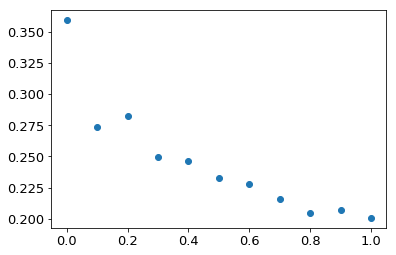

In [34]:
x = noises
y = system_scores
plt.plot(x, y, 'o')
print(scipy.stats.kendalltau(x, y))
print(np.mean(x), np.mean(y))

In [104]:
mu = 100
noise = 0.0

topic_scores = []
topic_scores_ses = []
for topic_id in tqdm(topics):
    num_subtopics = max(topics_to_subtopics_to_queries[topic_id].keys())

    dictionary, cl, lengths, inverted_index = get_search_engine(topic_id, noise)

    transitions_list = get_transitions_list(topic_id)
    table = get_transitions_table(num_subtopics, transitions_list, 0.01)
    
    # compute metric
    probs = []
    scores = []
    for n in range(5000):
        sequence, prob = generate_sequence_from_table(num_subtopics, table)
        probs.append(prob)
        score = 0.0
        for m, item in enumerate(sequence[:-1]):
            subtopic_id = item[1]
            if subtopic_id in topics_to_subtopics_to_queries[topic_id]:
                queries = topics_to_subtopics_to_queries[topic_id][subtopic_id]
                query = queries[choice(range(len(queries)))]
                answer = search(query, dictionary, cl, lengths, inverted_index, mu)
                is_rel = False
                if answer != None:
                    if answer[1] in topics_to_documents_to_subtopics[topic_id]:
                        is_rel = True #subtopic_id in topics_to_documents_to_subtopics[topic_id][answer[1]]
                if is_rel:
                    score += dd_ncbp(0.85, m)
                    #score += dd_cp(sequence)
        scores.append(score)

    if scores:
        probs = np.array(probs)
        scores = np.array(scores)
        #print(scores @ probs)
        #topic_score = (scores @ probs) / probs.sum()
        topic_score = np.mean(scores)
        topic_scores.append((topic_id, topic_score))
    else:
        topic_scores.append((topic_id, 0.0))

system_scores = sorted(topic_scores)
system_scores

[('1_harvard', 0.5790148921986314),
 ('2_blackdeath', 0.5242940382868144),
 ('3_ipcc', 0.5727974690150099),
 ('5_geology', 0.6035569458059715),
 ('6_economicinequality', 0.5308108315080482),
 ('7_immunesystem', 0.657528887902863),
 ('8_oxygen', 0.624416776021163)]

KendalltauResult(correlation=0.05292561240249632, pvalue=0.8738446985173735)


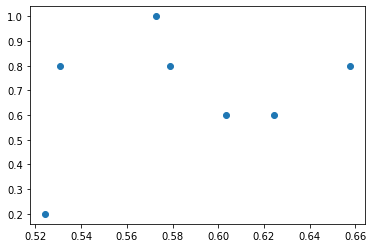

In [107]:
plt.plot([i[1] for i in system_scores], [i[1] for i in ncbp_scores], 'o')
print(kendalltau([i[1] for i in system_scores], [i[1] for i in ncbp_scores]))

In [123]:
mus = []
cbp_system_scores = []
cbp_system_score_ses = []
cp_system_scores = []
cp_system_score_ses = []
noises = []
mu = 1000
#for mu in tqdm(range(0, 10001, 500)):
noise = 0.1
for noise in tqdm(range(0, 11)):
    noise = noise / 10
    cbp_topic_scores = []
    cbp_topic_scores_ses = []
    cp_topic_scores = []
    cp_topic_scores_ses = []
    for topic_id in topics:
        num_subtopics = max(topics_to_subtopics_to_queries[topic_id].keys())
        # select documents belonging to the topic
        selected_documents = {}
        selected_documents[topic_id] = {}
        for document_id in documents[topic_id]:
            if document_id in topics_to_documents_to_subtopics[topic_id]:
                selected_documents[topic_id][document_id] = documents[topic_id][document_id]
        
        # select random documents
        dictionary, cl, lengths, inverted_index = get_search_engine(topic_id, noise)
        
        transitions_list = get_transitions_list(topic_id)
        table = get_transitions_table(num_subtopics, transitions_list)
        
        # compute metric
        probs = []
        cbp_scores = []
        cp_scores = []
        for n in range(5000):
            sequence, prob = generate_sequence_from_table(num_subtopics, table)
            probs.append(prob)
            cbp_score = 0.0
            cp_score = 0.0
            for m, item in enumerate(sequence[:-1]):
                subtopic_id = item[1]
                is_rel = False
                if subtopic_id in topics_to_subtopics_to_queries[topic_id]:
                    queries = topics_to_subtopics_to_queries[topic_id][subtopic_id]
                    query = queries[choice(range(len(queries)))]
                    answer = search(query, dictionary, cl, lengths, inverted_index, mu)
                    is_rel = False
                    if answer != None:
                        if answer[1] in topics_to_documents_to_subtopics[topic_id]:
                            is_rel = subtopic_id in topics_to_documents_to_subtopics[topic_id][answer[1]]
                if is_rel:
                    cbp_score += dd_ncbp(0.85, m)
                    #score += dd_cp(sequence)
        cbp_scores.append(score)
        
        if cbp_scores:
            probs = np.array(probs)
            cbp_scores = np.array(cbp_scores)
            cp_scores = np.array(cp_scores)
            #topic_score = (scores @ probs) / probs.sum()
            cbp_topic_score = np.mean(cbp_scores)
            cbp_topic_score_se = np.std(cbp_scores) / np.sqrt(len(cbp_scores))
            cbp_topic_scores.append(cbp_topic_score)
            cbp_topic_scores_ses.append(cbp_topic_score_se)
            cp_topic_score = np.mean(cp_scores)
            cp_topic_score_se = np.std(cp_scores) / np.sqrt(len(cbp_scores))
            cp_topic_scores.append(cp_topic_score)
            cp_topic_scores_ses.append(cp_topic_score_se)
        else:
            topic_scores.append(0)
        
    topic_scores = np.array(topic_scores)
    mus.append(mu)
    noises.append(noise)
    cbp_system_scores.append(np.mean(cbp_topic_scores))    
    cbp_system_score_ses = np.std(cbp_topic_scores) / np.sqrt(len(cbp_topic_scores))
    cp_system_scores.append(np.mean(cp_topic_scores))    
    cp_system_score_ses = np.std(cp_topic_scores) / np.sqrt(len(cp_topic_scores))
    
cbp_system_scores = np.array(cbp_system_scores)
cbp_system_score_ses = np.array(cbp_system_score_ses)
cp_system_scores = np.array(cp_system_scores)
cp_system_score_ses = np.array(cp_system_score_ses)
cbp_system_scores

array([0.55629469, 0.55629469, 0.55629469, 0.55629469, 0.55629469,
       0.55629469, 0.55629469, 0.55629469, 0.55629469, 0.55629469,
       0.55629469])

In [122]:
noises

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

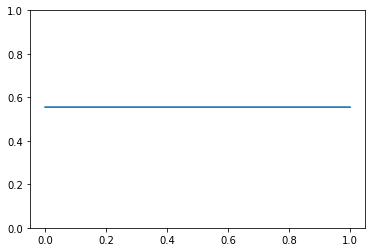

In [121]:
plt.ylim(0, 1)
plt.plot(noises, cbp_system_scores)
plt.fill_between(noises, cbp_system_scores - 1.96 * cbp_system_score_ses, cbp_system_scores + 1.96 * cbp_system_score_ses, color="gray")

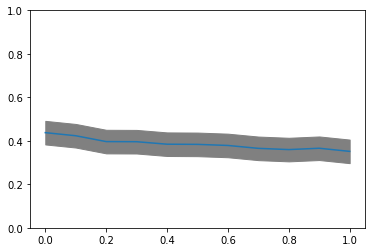

In [15]:
plt.ylim(0, 1)
plt.plot(noises, system_scores)
plt.fill_between(noises, system_scores - 1.96 * system_score_ses, system_scores + 1.96 * system_score_ses, color="gray")

In [27]:
kendalltau(cbp_system_scores, cp_system_scores)

KendalltauResult(correlation=0.9636363636363636, pvalue=5.511463844797178e-07)

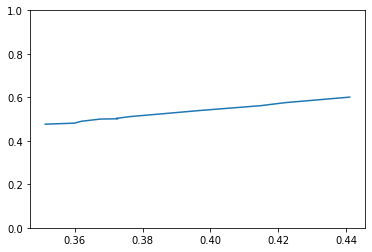

In [28]:
plt.ylim(0, 1)
plt.plot(cbp_system_scores, cp_system_scores)

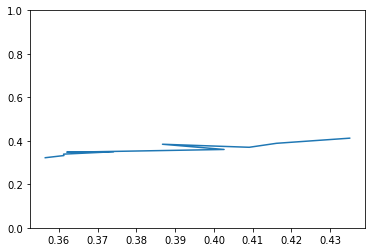

In [36]:
plt.ylim(0, 1)
plt.plot(cbp_system_scores, system_scores)

In [37]:
kendalltau(cbp_system_scores, system_scores)

KendalltauResult(correlation=0.8909090909090909, pvalue=1.3728555395222063e-05)

# Transition Probabilities

In [8]:
topic_id = "1_harvard"
transitions_list = get_transitions_list(topic_id)
num_subtopics = max(topics_to_subtopics_to_queries[topic_id].keys())
table = get_transitions_table(num_subtopics, transitions_list, 0.01)
to_matrix(table)

array([[0.2       , 0.0019802 , 0.2       , 0.2       , 0.3980198 ,
        0.        ],
       [0.00485437, 0.49029126, 0.49029126, 0.00485437, 0.00485437,
        0.00485437],
       [0.00124069, 0.12531017, 0.12531017, 0.37344913, 0.24937965,
        0.12531017],
       [0.00082919, 0.24958541, 0.49834163, 0.08374793, 0.00082919,
        0.16666667],
       [0.00141643, 0.28470255, 0.00141643, 0.14305949, 0.42634561,
        0.14305949],
       [0.11147903, 0.11147903, 0.33222958, 0.11147903, 0.2218543 ,
        0.11147903]])

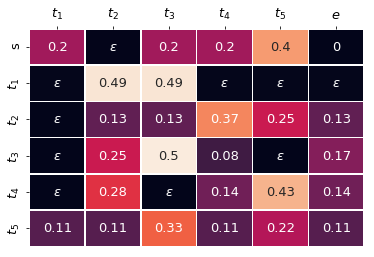

In [14]:
a = to_matrix(table)
plt.rc('font', size=13)
labels = np.copy(a)
labels = np.round_(labels, 2)
labels = labels.astype(str)
labels[a < 0.01] = "$\\varepsilon$"
labels[a == 0.0] = "0"
y_axis_labels = ["s", "$t_1$", "$t_2$", "$t_3$", "$t_4$", "$t_5$"]
x_axis_labels = ["$t_1$", "$t_2$", "$t_3$", "$t_4$", "$t_5$", "$e$"]
ax = sns.heatmap(a, xticklabels=x_axis_labels, yticklabels=y_axis_labels, vmin=0, vmax=0.5, annot=labels, linewidths=.5, fmt = '', cbar = False)
ax.xaxis.set_ticks_position('top')
plt.savefig("heat_map.png", dpi=300)

In [15]:
topic_id = "1_harvard"
transitions_list = get_transitions_list(topic_id, True)
rel_table, irr_table = get_transitions_tables(num_subtopics, transitions_list, 0.01)

In [16]:
to_matrix(rel_table)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.00943396, 0.00943396, 0.95283019, 0.00943396, 0.00943396,
        0.00943396],
       [0.00165017, 0.00165017, 0.00165017, 0.49669967, 0.33168317,
        0.16666667],
       [0.00124069, 0.24937965, 0.49751861, 0.12531017, 0.00124069,
        0.12531017],
       [0.00197628, 0.3972332 , 0.00197628, 0.19960474, 0.3972332 ,
        0.00197628],
       [0.14305949, 0.14305949, 0.28470255, 0.14305949, 0.14305949,
        0.14305949]])

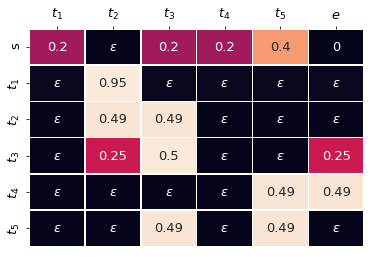

In [20]:
a = to_matrix(irr_table)
plt.rc('font', size=13)
labels = np.copy(a)
labels = np.round_(labels, 2)
labels = labels.astype(str)
labels[a < 0.01] = "$\\varepsilon$"
labels[a == 0.0] = "0"
y_axis_labels = ["s", "$t_1$", "$t_2$", "$t_3$", "$t_4$", "$t_5$"]
x_axis_labels = ["$t_1$", "$t_2$", "$t_3$", "$t_4$", "$t_5$", "$e$"]
ax = sns.heatmap(a, xticklabels=x_axis_labels, yticklabels=y_axis_labels, vmin=0, vmax=0.5, annot=labels, linewidths=.5, fmt = '', cbar = False)
ax.xaxis.set_ticks_position('top')
plt.savefig("heat_map_irrel.png", dpi=300)

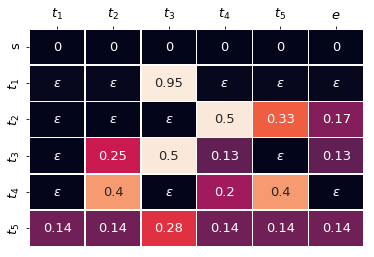

In [19]:
a = to_matrix(rel_table)
plt.rc('font', size=13)
labels = np.copy(a)
labels = np.round_(labels, 2)
labels = labels.astype(str)
labels[a < 0.01] = "$\\varepsilon$"
labels[a == 0.0] = "0"
y_axis_labels = ["s","$t_1$", "$t_2$", "$t_3$", "$t_4$", "$t_5$"]
x_axis_labels = ["$t_1$", "$t_2$", "$t_3$", "$t_4$", "$t_5$", "$e$"]
ax = sns.heatmap(a, xticklabels=x_axis_labels, yticklabels=y_axis_labels, vmin=0, vmax=0.5, annot=labels, linewidths=.5, fmt = '', cbar=False)
ax.xaxis.set_ticks_position('top')
plt.savefig("heat_map_rel.png", dpi=300)